In [1]:
from helpers import *
from dataset import *
from model2_for48 import *
from czii_helper import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torchvision.transforms as T
import cv2
import math
import cc3d
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, NormalizeIntensityd, ToTensorD
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import precision_score, recall_score, f1_score
from monai.transforms import RandFlipd,RandRotated,RandZoomd,RandAffined,ResizeD,SpatialPadd,RandRotate90d,EnsureChannelFirstd,Orientationd,RandAdjustContrastd,RandGaussianNoised

In [2]:
#DEBAG = False
DEBAG = True

In [3]:
MODE = 'local'
valid_dir = '../input/czii-cryo-et-object-identification/train'

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00010164-extern.pth',
   # '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.05,
    }, 
)

In [4]:
mask_size2 = {
    'defolt': 1,
    'apo-ferritin': mask_size["apo-ferritin"]*0.8,
    'beta-amylase':0,
    'beta-galactosidase': mask_size["beta-galactosidase"]*0.8,
    'ribosome': mask_size["ribosome"]*0.8,
    'thyroglobulin': mask_size["thyroglobulin"]*0.8,
    'virus-like-particle': mask_size["virus-like-particle"]*0.8,
}
print(mask_size2)
mask_check("TS_5_4",mask_size2,cfg)

{'defolt': 1, 'apo-ferritin': 4.800000000000001, 'beta-amylase': 0, 'beta-galactosidase': 7.2, 'ribosome': 12.0, 'thyroglobulin': 10.4, 'virus-like-particle': 10.8}
['TS_5_4']
 TS_5_4 virus-like-particle


(         particle_type   P   T  hit  miss  fp  precision    recall   f-beta4  \
 0         apo-ferritin  41  46   37     9   4   0.902439  0.804348  0.809524   
 1         beta-amylase  10  10   10     0   0   1.000000  1.000000  1.000000   
 2   beta-galactosidase  12  12   12     0   0   1.000000  1.000000  1.000000   
 3             ribosome  30  31   29     2   1   0.966667  0.935484  0.937262   
 4        thyroglobulin  30  30   30     0   0   1.000000  1.000000  1.000000   
 5  virus-like-particle  11  11   11     0   0   1.000000  1.000000  1.000000   
 
    weight  
 0       1  
 1       0  
 2       2  
 3       1  
 4       2  
 5       1  ,
 0.963826595276894)

(2, 184, 630, 630)
(2, 184, 630, 630)


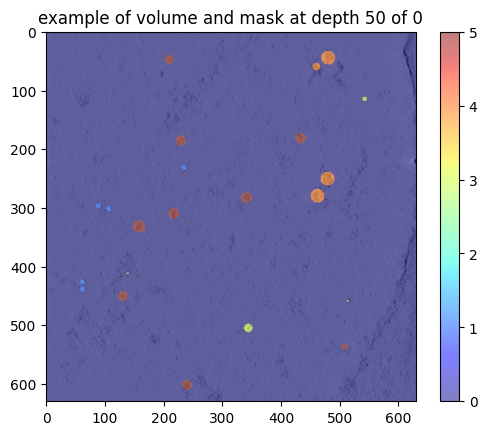

In [5]:
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved"]
#diff =["denoised","isonetcorrected","wbp","ctfdeconvolved","denoised"]
diff =["denoised"]

valid_id = ["TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3"]
if DEBAG:
    valid_id = ["TS_5_4",'TS_99_9',]
test_id = ["TS_5_4",'TS_99_9',]

volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(y, mask_size2)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

print_slices(volumes, masks,dim=4,idx=0,depth=50)

In [6]:
class VolumeDatasetSlices(Dataset):
    def __init__(self, vol_data, mask_data, patch_size=32, stride=16, transform=None):
        """
        Args:
            vol_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            mask_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            patch_size (int): 切り出したい深さ方向のスライス数 (例: 32)
            stride (int): スライドウィンドウの移動量 (例: 16)
            transform (callable, optional): MONAIの辞書ベースTransformsなど
        """
        self.vol_data = vol_data
        self.mask_data = mask_data
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.indices = []
        # 全サンプルに対してスライスの開始・終了位置をまとめる
        for idx in range(len(vol_data)):
            d = vol_data[idx].shape[0]  # 深さ(D次元)の大きさ
            # 0, stride, 2*stride, ... のように動かしながら、patch_sizeぶん取り出せる範囲でスライス
            for start in range(0, d - patch_size + 1, stride):
                #ランダムに動かす
                start = start 
                end = start + patch_size
                # (サンプル番号, スライス開始, スライス終了) を記録
                #マスクが含まれるスライスのみを記録
                if np.sum(mask_data[idx][start:end]) >= 0:
                    self.indices.append((idx, start, end))
            start = d - patch_size
            end = d
            if np.sum(mask_data[idx][start:end]) >= 0:
                self.indices.append((idx, start, end))


    def __len__(self):
        # スライスの総数を返す
        return len(self.indices)

    def __getitem__(self, i):
        idx, start, end = self.indices[i]

        # （idx番目のボリューム・マスク） のうち, 深さ方向を [start:end] で切り出す
        volume = self.vol_data[idx][start:end]  # (patch_size, H, W)
        mask   = self.mask_data[idx][start:end] # (patch_size, H, W)

        data_dict = {"image": volume, "label": mask}
        if self.transform:
            data_dict = self.transform(data_dict)

        return data_dict["image"], data_dict["label"]

# --- 使い方の例 ---

# 変換の定義
# ToTensorD で numpy -> torch.Tensor に変換し、さらに正規化を行う
transforms = Compose([
    # 1. Tensor形式に変換
    ToTensorD(keys=["image", "label"]),
    
    # 2. チャンネルの次元を先頭に移動
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    
    # 3. データをRAS方向に揃える
    Orientationd(keys=["image", "label"], axcodes="RAS"),
        
    # 4. ランダム90度回転を適用
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    
    # 5. ランダム反転 (空間軸 0 に沿って)
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    
    # 6. パディングを適用して (32, 640, 640) に拡張
    SpatialPadd(keys=["image", "label"], spatial_size=(32, 640, 640), mode="constant", method="end"),
    
])


In [7]:
dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=32, 
    stride=16,
    transform=transforms
)
raw_dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=32, 
    stride=16,
    transform=None
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
no_transform_dataloader = DataLoader(raw_dataset, batch_size=1, shuffle=True)
# データを取り出す
#i = 0
#print(len(dataloader))  # 6
#for volume, mask in dataloader:
#    i += 1
#    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
#    print_slices(volume[0], mask[0], dim=3, idx=0, depth=16)
#    if i == 3:
#        break

22
torch.Size([1, 1, 32, 640, 640]) torch.Size([1, 1, 32, 640, 640])


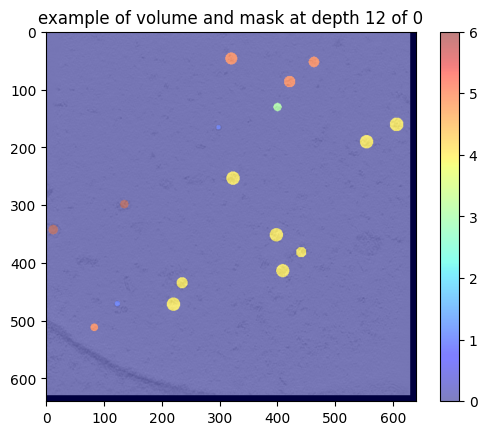

465538
torch.Size([1, 1, 32, 640, 640]) torch.Size([1, 1, 32, 640, 640])


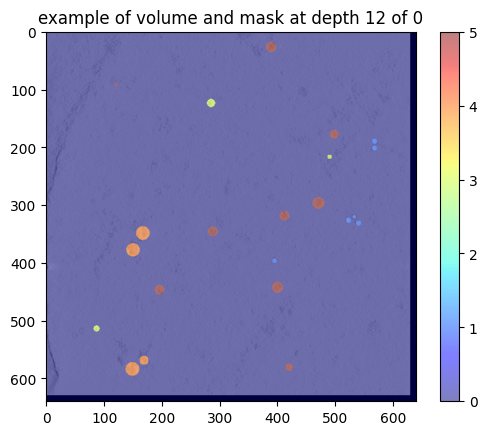

503029


In [8]:
 #データを取り出す
i = 0
print(len(dataloader))  # 6
for volume, mask in dataloader:
    i += 1
    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
    print_slices(volume[0], mask[0], dim=4, idx=0, depth=12)
    #print_volume_slices(mask[0], dim=4, idx=0, depth=12)
    print(np.sum(mask[0].numpy()))
    if i == 2:
        break

In [9]:
GPU_ID = 3
device = torch.device(f'cuda:{GPU_ID}' if torch.cuda.is_available() else 'cpu')
print(device)
net = Net(pretrained=False,cfg=None).to(device)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

cuda:3


In [10]:
global train_batch, test_batch

In [11]:
from torch.optim.lr_scheduler import LambdaLR
from IPython.display import clear_output
from tqdm import tqdm

# 学習ループにCV計算を追加
num_epochs = 300
learning_rate = 1e-3
accumulation_steps = 4  # 勾配を累積するステップ数

optimizer = torch.optim.AdamW(
    net.parameters(),
    amsgrad=False,
    betas=(0.9, 0.999),
    capturable=False,
    differentiable=False,
    eps=1e-08,
    foreach=None,
    fused=None,
    lr=learning_rate,
    weight_decay=0.01
)

warmup_steps = 30
total_steps = num_epochs * len(dataloader)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))  # 線形ウォームアップ
    return 0.5 * (1. + np.cos(np.pi * (current_step - warmup_steps) / (total_steps - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(init_scale=4096)

epoch_losses = []
cv_scores = []  # CVスコアの記録リスト
mask_losses = []

global_step = 0

for epoch in tqdm(range(num_epochs)):
    if False:  # epoch % 5 == 0 を無効化
        optimizer = torch.optim.AdamW(
            net.parameters(),
            amsgrad=False,
            betas=(0.9, 0.999),
            capturable=False,
            differentiable=False,
            eps=1e-08,
            foreach=None,
            fused=None,
            lr=learning_rate,
            weight_decay=0.01
        )

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        # 1次元削減
        volumes = volumes.squeeze(0)
        masks = masks.squeeze(0)

        batch, D, H, W = volumes.shape

        if np.sum(masks) == 0:
            continue
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }

        optimizer.zero_grad(set_to_none=True) if i % accumulation_steps == 0 else None

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss'] / accumulation_steps  # 累積ステップ数でスケーリング

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            global_step += 1

        running_loss += loss.item() * accumulation_steps  # スケーリングを戻して加算

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"train_loss: {epoch_loss:.4f}")
    # 15エポックごとにCVスコアを計算
    if  epoch  % 5 == 0:
        gb, lb_score, mask_loss,probability = evaluate_cv(net, test_id, cfg, valid_dir, device, mask_size2)
        print(f"valid_loss: {np.mean(mask_loss):.4f}")
        print(f"CVスコア {lb_score:.4f}")  # test_id: 検証用データIDリスト
        print(gb[["particle_type", "P", "T", "hit", "precision", "recall", "f-beta4"]])
    cv_scores.append(lb_score)
    #lbスコアが最大のモデルを保存
    if lb_score == max(cv_scores):
        torch.save({'state_dict': net.state_dict()}, '../model/resnet34d.pth')
    mask_losses.append(np.mean(mask_loss))

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  0%|          | 0/300 [00:00<?, ?it/s]

エポック 1/300
----------
train_loss: 2.0630
valid_loss: 1.9344
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  2  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


  0%|          | 1/300 [00:50<4:10:18, 50.23s/it]

エポック 2/300
----------
train_loss: 1.8575


  1%|          | 2/300 [01:05<2:27:05, 29.62s/it]

エポック 3/300
----------
train_loss: 1.7403


  1%|          | 3/300 [01:20<1:53:38, 22.96s/it]

エポック 4/300
----------
train_loss: 1.6625


  1%|▏         | 4/300 [01:35<1:38:07, 19.89s/it]

エポック 5/300
----------
train_loss: 1.5926


  2%|▏         | 5/300 [01:50<1:29:04, 18.12s/it]

エポック 6/300
----------
train_loss: 1.5240
valid_loss: 1.4935
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  2  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


  2%|▏         | 6/300 [02:42<2:24:35, 29.51s/it]

エポック 7/300
----------
train_loss: 1.4578


  2%|▏         | 7/300 [02:57<2:01:11, 24.82s/it]

エポック 8/300
----------
train_loss: 1.3905


  3%|▎         | 8/300 [03:12<1:45:43, 21.73s/it]

エポック 9/300
----------
train_loss: 1.3265


  3%|▎         | 9/300 [03:27<1:35:18, 19.65s/it]

エポック 10/300
----------
train_loss: 1.2639


  3%|▎         | 10/300 [03:42<1:28:13, 18.25s/it]

エポック 11/300
----------
train_loss: 1.2025
valid_loss: 1.1798
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  2  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


  4%|▎         | 11/300 [04:30<2:11:53, 27.38s/it]

エポック 12/300
----------
train_loss: 1.1420


  4%|▍         | 12/300 [04:45<1:53:09, 23.57s/it]

エポック 13/300
----------
train_loss: 1.0826


  4%|▍         | 13/300 [05:00<1:40:39, 21.04s/it]

エポック 14/300
----------
train_loss: 1.0243


  5%|▍         | 14/300 [05:15<1:31:26, 19.18s/it]

エポック 15/300
----------
train_loss: 0.9671


  5%|▌         | 15/300 [05:31<1:25:30, 18.00s/it]

エポック 16/300
----------
train_loss: 0.9109
valid_loss: 0.9089
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  2  82    0        0.0     0.0      0.0
1         beta-amylase  2  31    0        0.0     0.0      0.0
2   beta-galactosidase  2  36    0        0.0     0.0      0.0
3             ribosome  2  96    0        0.0     0.0      0.0
4        thyroglobulin  2  79    0        0.0     0.0      0.0
5  virus-like-particle  2  24    0        0.0     0.0      0.0


  5%|▌         | 16/300 [06:18<2:07:37, 26.96s/it]

エポック 17/300
----------
train_loss: 0.8555


  6%|▌         | 17/300 [06:33<1:50:14, 23.37s/it]

エポック 18/300
----------
train_loss: 0.8003


  6%|▌         | 18/300 [06:48<1:38:13, 20.90s/it]

エポック 19/300
----------
train_loss: 0.7456


  6%|▋         | 19/300 [07:03<1:29:31, 19.11s/it]

エポック 20/300
----------
train_loss: 0.6944


  7%|▋         | 20/300 [07:18<1:23:20, 17.86s/it]

エポック 21/300
----------
train_loss: 0.6444
valid_loss: 0.6428
CVスコア 0.0062
         particle_type      P   T  hit  precision    recall   f-beta4
0         apo-ferritin   7316  82    2   0.000273  0.024390  0.003941
1         beta-amylase      2  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase      2  36    0   0.000000  0.000000  0.000000
3             ribosome      2  96    0   0.000000  0.000000  0.000000
4        thyroglobulin  11677  79   15   0.001285  0.189873  0.019705
5  virus-like-particle      2  24    0   0.000000  0.000000  0.000000


  7%|▋         | 21/300 [08:06<2:04:50, 26.85s/it]

エポック 22/300
----------
train_loss: 0.5965


  7%|▋         | 22/300 [08:21<1:48:04, 23.33s/it]

エポック 23/300
----------
train_loss: 0.5503


  8%|▊         | 23/300 [08:37<1:36:51, 20.98s/it]

エポック 24/300
----------
train_loss: 0.5073


  8%|▊         | 24/300 [08:52<1:28:31, 19.24s/it]

エポック 25/300
----------
train_loss: 0.4674


  8%|▊         | 25/300 [09:07<1:22:36, 18.02s/it]

エポック 26/300
----------
train_loss: 0.4312
valid_loss: 0.4163
CVスコア 0.0541
         particle_type      P   T  hit  precision    recall   f-beta4
0         apo-ferritin   2023  82    7   0.003460  0.085366  0.035682
1         beta-amylase    473  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  11049  36    2   0.000181  0.055556  0.002925
3             ribosome      3  96    0   0.000000  0.000000  0.000000
4        thyroglobulin   1764  79   30   0.017007  0.379747  0.168428
5  virus-like-particle      2  24    0   0.000000  0.000000  0.000000


  9%|▊         | 26/300 [09:55<2:03:10, 26.97s/it]

エポック 27/300
----------
train_loss: 0.4005


  9%|▉         | 27/300 [10:11<1:47:13, 23.57s/it]

エポック 28/300
----------
train_loss: 0.3717


  9%|▉         | 28/300 [10:26<1:35:42, 21.11s/it]

エポック 29/300
----------
train_loss: 0.3434


 10%|▉         | 29/300 [10:41<1:27:19, 19.34s/it]

エポック 30/300
----------
train_loss: 0.3177


 10%|█         | 30/300 [10:57<1:21:36, 18.13s/it]

エポック 31/300
----------
train_loss: 0.2939
valid_loss: 0.3250
CVスコア 0.0972
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  1438  82   11   0.007650  0.134146  0.068000
1         beta-amylase  2256  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  3578  36   19   0.005310  0.527778  0.077756
3             ribosome  3744  96    0   0.000000  0.000000  0.000000
4        thyroglobulin  1417  79   36   0.025406  0.455696  0.228273
5  virus-like-particle   299  24    0   0.000000  0.000000  0.000000


 10%|█         | 31/300 [11:44<2:00:53, 26.96s/it]

エポック 32/300
----------
train_loss: 0.2723


 11%|█         | 32/300 [11:59<1:44:35, 23.42s/it]

エポック 33/300
----------
train_loss: 0.2531


 11%|█         | 33/300 [12:14<1:33:03, 20.91s/it]

エポック 34/300
----------
train_loss: 0.2357


 11%|█▏        | 34/300 [12:30<1:25:06, 19.20s/it]

エポック 35/300
----------
train_loss: 0.2204


 12%|█▏        | 35/300 [12:45<1:19:35, 18.02s/it]

エポック 36/300
----------
train_loss: 0.2065


 12%|█▏        | 36/300 [13:30<1:55:05, 26.16s/it]

valid_loss: 0.2706
CVスコア 0.0874
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  1485  82    7   0.004714  0.085366  0.042546
1         beta-amylase  4886  31    3   0.000614  0.096774  0.009476
2   beta-galactosidase  2262  36   12   0.005305  0.333333  0.071882
3             ribosome  3224  96    1   0.000310  0.010417  0.003571
4        thyroglobulin  1637  79   36   0.021991  0.455696  0.210962
5  virus-like-particle  3471  24    0   0.000000  0.000000  0.000000
エポック 37/300
----------


 12%|█▏        | 37/300 [13:43<1:38:00, 22.36s/it]

train_loss: 0.1939
エポック 38/300
----------


 13%|█▎        | 38/300 [13:57<1:26:16, 19.76s/it]

train_loss: 0.1828
エポック 39/300
----------


 13%|█▎        | 39/300 [14:11<1:18:02, 17.94s/it]

train_loss: 0.1725
エポック 40/300
----------


 13%|█▎        | 40/300 [14:25<1:12:24, 16.71s/it]

train_loss: 0.1637
エポック 41/300
----------
train_loss: 0.1550
valid_loss: 0.1616
CVスコア 0.1573
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin   358  82    5   0.013966  0.060976  0.050898
1         beta-amylase   765  31    2   0.002614  0.064516  0.026963
2   beta-galactosidase   431  36    7   0.016241  0.194444  0.118173
3             ribosome   752  96   38   0.050532  0.395833  0.282343
4        thyroglobulin   380  79   22   0.057895  0.278481  0.227494
5  virus-like-particle  1609  24    9   0.005594  0.375000  0.076769


 14%|█▎        | 41/300 [15:10<1:48:57, 25.24s/it]

エポック 42/300
----------
train_loss: 0.1474


 14%|█▍        | 42/300 [15:25<1:35:01, 22.10s/it]

エポック 43/300
----------
train_loss: 0.1407


 14%|█▍        | 43/300 [15:40<1:25:38, 19.99s/it]

エポック 44/300
----------
train_loss: 0.1343


 15%|█▍        | 44/300 [15:55<1:19:07, 18.55s/it]

エポック 45/300
----------
train_loss: 0.1294


 15%|█▌        | 45/300 [16:10<1:14:19, 17.49s/it]

エポック 46/300
----------
train_loss: 0.1241


 15%|█▌        | 46/300 [16:54<1:48:19, 25.59s/it]

valid_loss: 0.1754
CVスコア 0.0797
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin  1909  82   11   0.005762  0.134146  0.058057
1         beta-amylase  3068  31    4   0.001304  0.129032  0.019080
2   beta-galactosidase  3009  36    9   0.002991  0.250000  0.042678
3             ribosome  3874  96    2   0.000516  0.020833  0.006285
4        thyroglobulin  2263  79   40   0.017676  0.506329  0.192798
5  virus-like-particle  4111  24    6   0.001459  0.250000  0.022692
エポック 47/300
----------


 16%|█▌        | 47/300 [17:08<1:32:33, 21.95s/it]

train_loss: 0.1195
エポック 48/300
----------


 16%|█▌        | 48/300 [17:21<1:21:41, 19.45s/it]

train_loss: 0.1146
エポック 49/300
----------


 16%|█▋        | 49/300 [17:35<1:14:01, 17.69s/it]

train_loss: 0.1100
エポック 50/300
----------


 17%|█▋        | 50/300 [17:49<1:08:41, 16.49s/it]

train_loss: 0.1069
エポック 51/300
----------
train_loss: 0.1027


 17%|█▋        | 51/300 [18:34<1:43:51, 25.02s/it]

valid_loss: 0.1182
CVスコア 0.1482
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin   563  82    7   0.012433  0.085366  0.063467
1         beta-amylase  1082  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   692  36    5   0.007225  0.138889  0.067035
3             ribosome  1202  96   21   0.017471  0.218750  0.130387
4        thyroglobulin   667  79   37   0.055472  0.468354  0.325738
5  virus-like-particle  2256  24    9   0.003989  0.375000  0.057955
エポック 52/300
----------


 17%|█▋        | 52/300 [18:47<1:29:16, 21.60s/it]

train_loss: 0.0985
エポック 53/300
----------


 18%|█▊        | 53/300 [19:01<1:19:01, 19.20s/it]

train_loss: 0.0957
エポック 54/300
----------


 18%|█▊        | 54/300 [19:15<1:12:04, 17.58s/it]

train_loss: 0.0928
エポック 55/300
----------


 18%|█▊        | 55/300 [19:28<1:07:04, 16.43s/it]

train_loss: 0.0900
エポック 56/300
----------
train_loss: 0.0870


 19%|█▊        | 56/300 [20:12<1:39:53, 24.56s/it]

valid_loss: 0.0985
CVスコア 0.1534
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  252  82    1   0.003968  0.012195  0.010870
1         beta-amylase  231  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  164  36    0   0.000000  0.000000  0.000000
3             ribosome  416  96   47   0.112981  0.489583  0.409324
4        thyroglobulin  308  79   24   0.077922  0.303797  0.259542
5  virus-like-particle  375  24    6   0.016000  0.250000  0.134387
エポック 57/300
----------


 19%|█▉        | 57/300 [20:25<1:26:08, 21.27s/it]

train_loss: 0.0846
エポック 58/300
----------


 19%|█▉        | 58/300 [20:39<1:16:26, 18.95s/it]

train_loss: 0.0818
エポック 59/300
----------


 20%|█▉        | 59/300 [20:53<1:09:41, 17.35s/it]

train_loss: 0.0798
エポック 60/300
----------


 20%|██        | 60/300 [21:06<1:05:00, 16.25s/it]

train_loss: 0.0780
エポック 61/300
----------
train_loss: 0.0767


 20%|██        | 61/300 [21:51<1:38:46, 24.80s/it]

valid_loss: 0.0954
CVスコア 0.1315
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin   744  82    3   0.004032  0.036585  0.024805
1         beta-amylase   626  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   452  36    4   0.008850  0.111111  0.066148
3             ribosome  1335  96   31   0.023221  0.322917  0.183560
4        thyroglobulin   970  79   36   0.037113  0.455696  0.273948
5  virus-like-particle  1754  24    4   0.002281  0.166667  0.031805
エポック 62/300
----------


 21%|██        | 62/300 [22:05<1:25:00, 21.43s/it]

train_loss: 0.0746
エポック 63/300
----------


 21%|██        | 63/300 [22:18<1:15:27, 19.10s/it]

train_loss: 0.0726
エポック 64/300
----------


 21%|██▏       | 64/300 [22:32<1:08:42, 17.47s/it]

train_loss: 0.0712
エポック 65/300
----------


 22%|██▏       | 65/300 [22:46<1:04:03, 16.35s/it]

train_loss: 0.0693
エポック 66/300
----------
train_loss: 0.0677


 22%|██▏       | 66/300 [23:30<1:36:49, 24.83s/it]

valid_loss: 0.0806
CVスコア 0.1544
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  233  82    2   0.008584  0.024390  0.022006
1         beta-amylase  170  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  167  36    0   0.000000  0.000000  0.000000
3             ribosome  424  96   41   0.096698  0.427083  0.355612
4        thyroglobulin  324  79   23   0.070988  0.291139  0.246222
5  virus-like-particle  343  24    9   0.026239  0.375000  0.210454
エポック 67/300
----------


 22%|██▏       | 67/300 [23:44<1:23:20, 21.46s/it]

train_loss: 0.0664
エポック 68/300
----------


 23%|██▎       | 68/300 [23:58<1:13:58, 19.13s/it]

train_loss: 0.0650
エポック 69/300
----------


 23%|██▎       | 69/300 [24:11<1:07:14, 17.47s/it]

train_loss: 0.0643
エポック 70/300
----------


 23%|██▎       | 70/300 [24:25<1:02:42, 16.36s/it]

train_loss: 0.0632
エポック 71/300
----------
train_loss: 0.0618


 24%|██▎       | 71/300 [25:08<1:33:19, 24.45s/it]

valid_loss: 0.0860
CVスコア 0.0016
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   4  82    0   0.000000  0.000000  0.000000
1         beta-amylase   5  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   1  36    0   0.000000  0.000000  0.000000
3             ribosome  12  96    1   0.083333  0.010417  0.010982
4        thyroglobulin   5  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  48  24    0   0.000000  0.000000  0.000000
エポック 72/300
----------


 24%|██▍       | 72/300 [25:22<1:20:31, 21.19s/it]

train_loss: 0.0611
エポック 73/300
----------


 24%|██▍       | 73/300 [25:36<1:11:39, 18.94s/it]

train_loss: 0.0601
エポック 74/300
----------


 25%|██▍       | 74/300 [25:49<1:05:27, 17.38s/it]

train_loss: 0.0602
エポック 75/300
----------


 25%|██▌       | 75/300 [26:03<1:01:04, 16.29s/it]

train_loss: 0.0582
エポック 76/300
----------
train_loss: 0.0581
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 25%|██▌       | 76/300 [26:46<1:31:06, 24.40s/it]

valid_loss: 0.0839
CVスコア 0.0831
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   66  36    0   0.000000  0.000000  0.000000
1         beta-amylase    7  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    8  24    0   0.000000  0.000000  0.000000
3             ribosome  214  65   39   0.182243  0.600000  0.528708
4        thyroglobulin  144  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  111  13    1   0.009009  0.076923  0.053292
エポック 77/300
----------


 26%|██▌       | 77/300 [27:00<1:18:40, 21.17s/it]

train_loss: 0.0566
エポック 78/300
----------


 26%|██▌       | 78/300 [27:14<1:09:58, 18.91s/it]

train_loss: 0.0557
エポック 79/300
----------


 26%|██▋       | 79/300 [27:27<1:03:52, 17.34s/it]

train_loss: 0.0540
エポック 80/300
----------


 27%|██▋       | 80/300 [27:41<59:36, 16.26s/it]  

train_loss: 0.0540
エポック 81/300
----------
train_loss: 0.0539
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 27%|██▋       | 81/300 [28:24<1:29:02, 24.40s/it]

valid_loss: 0.0689
CVスコア 0.1074
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  104  36    0   0.000000  0.000000  0.000000
1         beta-amylase   36  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   21  24    0   0.000000  0.000000  0.000000
3             ribosome  258  65   43   0.166667  0.661538  0.563174
4        thyroglobulin  212  49    4   0.018868  0.081633  0.068273
5  virus-like-particle  120  13    1   0.008333  0.076923  0.051829
エポック 82/300
----------


 27%|██▋       | 82/300 [28:38<1:16:51, 21.15s/it]

train_loss: 0.0524
エポック 83/300
----------


 28%|██▊       | 83/300 [28:52<1:08:16, 18.88s/it]

train_loss: 0.0528
エポック 84/300
----------


 28%|██▊       | 84/300 [29:05<1:02:24, 17.34s/it]

train_loss: 0.0515
エポック 85/300
----------


 28%|██▊       | 85/300 [29:19<58:10, 16.23s/it]  

train_loss: 0.0503
エポック 86/300
----------
train_loss: 0.0498


 29%|██▊       | 86/300 [30:02<1:26:52, 24.36s/it]

valid_loss: 0.0748
CVスコア 0.0763
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   84  82    0   0.000000  0.000000  0.000000
1         beta-amylase   47  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   43  36    0   0.000000  0.000000  0.000000
3             ribosome  216  96   38   0.175926  0.395833  0.368721
4        thyroglobulin  154  79    4   0.025974  0.050633  0.047955
5  virus-like-particle  107  24    2   0.018692  0.083333  0.069246
エポック 87/300
----------


 29%|██▉       | 87/300 [30:16<1:15:03, 21.14s/it]

train_loss: 0.0479
エポック 88/300
----------


 29%|██▉       | 88/300 [30:30<1:06:45, 18.89s/it]

train_loss: 0.0477
エポック 89/300
----------


 30%|██▉       | 89/300 [30:43<1:00:59, 17.34s/it]

train_loss: 0.0469
エポック 90/300
----------


 30%|███       | 90/300 [30:57<56:51, 16.25s/it]  

train_loss: 0.0484
エポック 91/300
----------
train_loss: 0.0464
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 30%|███       | 91/300 [31:40<1:24:37, 24.29s/it]

valid_loss: 0.0806
CVスコア 0.0248
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  12  36    0   0.000000  0.000000  0.000000
1         beta-amylase   3  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   2  24    0   0.000000  0.000000  0.000000
3             ribosome  38  65   11   0.289474  0.169231  0.173469
4        thyroglobulin  31  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  18  13    0   0.000000  0.000000  0.000000
エポック 92/300
----------


 31%|███       | 92/300 [31:54<1:13:09, 21.10s/it]

train_loss: 0.0457
エポック 93/300
----------


 31%|███       | 93/300 [32:07<1:04:57, 18.83s/it]

train_loss: 0.0441
エポック 94/300
----------


 31%|███▏      | 94/300 [32:21<59:20, 17.28s/it]  

train_loss: 0.0437
エポック 95/300
----------


 32%|███▏      | 95/300 [32:35<55:21, 16.20s/it]

train_loss: 0.0440
エポック 96/300
----------
train_loss: 0.0438
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 32%|███▏      | 96/300 [33:18<1:22:31, 24.27s/it]

valid_loss: 0.0813
CVスコア 0.0023
         particle_type  P   T  hit  precision    recall   f-beta4
0         apo-ferritin  0  36    0        0.0  0.000000  0.000000
1         beta-amylase  3  21    0        0.0  0.000000  0.000000
2   beta-galactosidase  0  24    0        0.0  0.000000  0.000000
3             ribosome  2  65    1        0.5  0.015385  0.016315
4        thyroglobulin  1  49    0        0.0  0.000000  0.000000
5  virus-like-particle  5  13    0        0.0  0.000000  0.000000
エポック 97/300
----------


 32%|███▏      | 97/300 [33:31<1:11:22, 21.10s/it]

train_loss: 0.0422
エポック 98/300
----------


 33%|███▎      | 98/300 [33:45<1:03:27, 18.85s/it]

train_loss: 0.0423
エポック 99/300
----------


 33%|███▎      | 99/300 [33:59<57:50, 17.27s/it]  

train_loss: 0.0422
エポック 100/300
----------


 33%|███▎      | 100/300 [34:12<54:00, 16.20s/it]

train_loss: 0.0412
エポック 101/300
----------
train_loss: 0.0409
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 34%|███▎      | 101/300 [34:56<1:20:48, 24.36s/it]

valid_loss: 0.0833
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  1  36    0        0.0     0.0      0.0
1         beta-amylase  5  21    0        0.0     0.0      0.0
2   beta-galactosidase  0  24    0        0.0     0.0      0.0
3             ribosome  2  65    0        0.0     0.0      0.0
4        thyroglobulin  3  49    0        0.0     0.0      0.0
5  virus-like-particle  7  13    0        0.0     0.0      0.0
エポック 102/300
----------


 34%|███▍      | 102/300 [35:09<1:09:45, 21.14s/it]

train_loss: 0.0394
エポック 103/300
----------


 34%|███▍      | 103/300 [35:23<1:02:03, 18.90s/it]

train_loss: 0.0395
エポック 104/300
----------


 35%|███▍      | 104/300 [35:37<56:36, 17.33s/it]  

train_loss: 0.0392
エポック 105/300
----------


 35%|███▌      | 105/300 [35:50<52:42, 16.22s/it]

train_loss: 0.0382
エポック 106/300
----------
train_loss: 0.0383
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 35%|███▌      | 106/300 [36:34<1:18:43, 24.35s/it]

valid_loss: 0.0794
CVスコア 0.0963
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   92  36    5   0.054348  0.138889  0.127246
1         beta-amylase   21  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   16  24    0   0.000000  0.000000  0.000000
3             ribosome  469  65   13   0.027719  0.200000  0.146455
4        thyroglobulin  291  49   11   0.037801  0.224490  0.173953
5  virus-like-particle  118  13    1   0.008475  0.076923  0.052147
エポック 107/300
----------


 36%|███▌      | 107/300 [36:47<1:07:55, 21.12s/it]

train_loss: 0.0373
エポック 108/300
----------


 36%|███▌      | 108/300 [37:01<1:00:19, 18.85s/it]

train_loss: 0.0369
エポック 109/300
----------


 36%|███▋      | 109/300 [37:14<55:04, 17.30s/it]  

train_loss: 0.0377
エポック 110/300
----------


 37%|███▋      | 110/300 [37:28<51:20, 16.21s/it]

train_loss: 0.0370
エポック 111/300
----------
train_loss: 0.0360
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0580
CVスコア 0.2892
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  404  36   20   0.049505  0.555556  0.346939
1         beta-amylase  245  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  233  24    3   0.012876  0.125000  0.082658
3             ribosome  856  65   33   0.038551  0.507692  0.295886
4        thyroglobulin  756  49   41   0.054233  0.836735  0.452597
5  virus-like-particle  448  13   12   0.026786  0.923077  0.310976


 37%|███▋      | 111/300 [38:13<1:18:20, 24.87s/it]

エポック 112/300
----------
train_loss: 0.0359


 37%|███▋      | 112/300 [38:28<1:08:39, 21.91s/it]

エポック 113/300
----------
train_loss: 0.0353


 38%|███▊      | 113/300 [38:43<1:01:47, 19.83s/it]

エポック 114/300
----------
train_loss: 0.0364


 38%|███▊      | 114/300 [38:58<57:01, 18.40s/it]  

エポック 115/300
----------
train_loss: 0.0353


 38%|███▊      | 115/300 [39:13<53:43, 17.42s/it]

エポック 116/300
----------
train_loss: 0.0362
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0580
CVスコア 0.3309
         particle_type     P   T  hit  precision    recall   f-beta4
0         apo-ferritin   728  36   24   0.032967  0.666667  0.312883
1         beta-amylase   549  21    3   0.005464  0.142857  0.057627
2   beta-galactosidase   476  24   19   0.039916  0.791667  0.375581
3             ribosome  1006  65   35   0.034791  0.538462  0.290811
4        thyroglobulin   972  49   40   0.041152  0.816327  0.387244
5  virus-like-particle   974  13   13   0.013347  1.000000  0.186971


 39%|███▊      | 116/300 [39:59<1:19:15, 25.85s/it]

エポック 117/300
----------
train_loss: 0.0354


 39%|███▉      | 117/300 [40:14<1:09:05, 22.65s/it]

エポック 118/300
----------
train_loss: 0.0348


 39%|███▉      | 118/300 [40:29<1:01:50, 20.39s/it]

エポック 119/300
----------
train_loss: 0.0340


 40%|███▉      | 119/300 [40:44<56:46, 18.82s/it]  

エポック 120/300
----------
train_loss: 0.0329


 40%|████      | 120/300 [40:59<53:03, 17.69s/it]

エポック 121/300
----------
train_loss: 0.0328
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 40%|████      | 121/300 [41:42<1:15:30, 25.31s/it]

valid_loss: 0.0821
CVスコア 0.0000
         particle_type  P   T  hit  precision  recall  f-beta4
0         apo-ferritin  1  36    0        0.0     0.0      0.0
1         beta-amylase  2  21    0        0.0     0.0      0.0
2   beta-galactosidase  0  24    0        0.0     0.0      0.0
3             ribosome  1  65    0        0.0     0.0      0.0
4        thyroglobulin  1  49    0        0.0     0.0      0.0
5  virus-like-particle  5  13    0        0.0     0.0      0.0
エポック 122/300
----------


 41%|████      | 122/300 [41:56<1:04:39, 21.79s/it]

train_loss: 0.0322
エポック 123/300
----------


 41%|████      | 123/300 [42:10<56:59, 19.32s/it]  

train_loss: 0.0318
エポック 124/300
----------


 41%|████▏     | 124/300 [42:23<51:40, 17.62s/it]

train_loss: 0.0312
エポック 125/300
----------


 42%|████▏     | 125/300 [42:37<47:50, 16.40s/it]

train_loss: 0.0306
エポック 126/300
----------
train_loss: 0.0305
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 42%|████▏     | 126/300 [43:20<1:10:48, 24.42s/it]

valid_loss: 0.0798
CVスコア 0.1271
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   77  36   17   0.220779  0.472222  0.442573
1         beta-amylase   47  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   48  24    1   0.020833  0.041667  0.039352
3             ribosome  344  65    8   0.023256  0.123077  0.098266
4        thyroglobulin  237  49    4   0.016878  0.081633  0.066601
5  virus-like-particle  164  13    3   0.018293  0.230769  0.137097
エポック 127/300
----------


 42%|████▏     | 127/300 [43:33<1:00:56, 21.14s/it]

train_loss: 0.0308
エポック 128/300
----------


 43%|████▎     | 128/300 [43:47<54:05, 18.87s/it]  

train_loss: 0.0305
エポック 129/300
----------


 43%|████▎     | 129/300 [44:01<49:19, 17.31s/it]

train_loss: 0.0302
エポック 130/300
----------


 43%|████▎     | 130/300 [44:14<45:51, 16.18s/it]

train_loss: 0.0293
エポック 131/300
----------
train_loss: 0.0303
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 44%|████▎     | 131/300 [44:58<1:08:32, 24.34s/it]

valid_loss: 0.0814
CVスコア 0.0503
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  21  36    8   0.380952  0.222222  0.227806
1         beta-amylase  18  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  17  24    0   0.000000  0.000000  0.000000
3             ribosome  97  65    4   0.041237  0.061538  0.059807
4        thyroglobulin  63  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  56  13    1   0.017857  0.076923  0.064394
エポック 132/300
----------


 44%|████▍     | 132/300 [45:11<59:05, 21.11s/it]  

train_loss: 0.0294
エポック 133/300
----------


 44%|████▍     | 133/300 [45:25<52:33, 18.88s/it]

train_loss: 0.0298
エポック 134/300
----------


 45%|████▍     | 134/300 [45:39<47:55, 17.32s/it]

train_loss: 0.0296
エポック 135/300
----------


 45%|████▌     | 135/300 [45:52<44:37, 16.22s/it]

train_loss: 0.0293
エポック 136/300
----------
train_loss: 0.0289
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 45%|████▌     | 136/300 [46:35<1:06:19, 24.26s/it]

valid_loss: 0.0815
CVスコア 0.0690
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  22  36   17   0.772727  0.472222  0.483278
1         beta-amylase  20  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  22  24    0   0.000000  0.000000  0.000000
3             ribosome  34  65    0   0.000000  0.000000  0.000000
4        thyroglobulin  30  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  50  13    0   0.000000  0.000000  0.000000
エポック 137/300
----------


 46%|████▌     | 137/300 [46:49<57:13, 21.06s/it]  

train_loss: 0.0284
エポック 138/300
----------


 46%|████▌     | 138/300 [47:02<50:48, 18.82s/it]

train_loss: 0.0281
エポック 139/300
----------


 46%|████▋     | 139/300 [47:16<46:20, 17.27s/it]

train_loss: 0.0278
エポック 140/300
----------


 47%|████▋     | 140/300 [47:30<43:15, 16.22s/it]

train_loss: 0.0274
エポック 141/300
----------
train_loss: 0.0275


 47%|████▋     | 141/300 [48:13<1:04:41, 24.41s/it]

valid_loss: 0.0725
CVスコア 0.2012
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  268  82   32   0.119403  0.390244  0.344304
1         beta-amylase  112  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  214  36    5   0.023364  0.138889  0.107595
3             ribosome  837  96   52   0.062127  0.541667  0.372524
4        thyroglobulin  479  79   20   0.041754  0.253165  0.195066
5  virus-like-particle  994  24    7   0.007042  0.291667  0.086357
エポック 142/300
----------


 47%|████▋     | 142/300 [48:27<55:43, 21.16s/it]  

train_loss: 0.0277
エポック 143/300
----------


 48%|████▊     | 143/300 [48:41<49:28, 18.91s/it]

train_loss: 0.0265
エポック 144/300
----------


 48%|████▊     | 144/300 [48:54<45:06, 17.35s/it]

train_loss: 0.0273
エポック 145/300
----------


 48%|████▊     | 145/300 [49:08<42:05, 16.29s/it]

train_loss: 0.0270
エポック 146/300
----------
train_loss: 0.0271
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 49%|████▊     | 146/300 [49:51<1:02:37, 24.40s/it]

valid_loss: 0.0814
CVスコア 0.0093
         particle_type  P   T  hit  precision    recall   f-beta4
0         apo-ferritin  0  36    0   0.000000  0.000000  0.000000
1         beta-amylase  0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  0  24    0   0.000000  0.000000  0.000000
3             ribosome  9  65    4   0.444444  0.061538  0.064824
4        thyroglobulin  1  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  5  13    0   0.000000  0.000000  0.000000
エポック 147/300
----------


 49%|████▉     | 147/300 [50:05<54:05, 21.21s/it]  

train_loss: 0.0253
エポック 148/300
----------


 49%|████▉     | 148/300 [50:19<47:57, 18.93s/it]

train_loss: 0.0245
エポック 149/300
----------


 50%|████▉     | 149/300 [50:32<43:40, 17.35s/it]

train_loss: 0.0233
エポック 150/300
----------


 50%|█████     | 150/300 [50:46<40:36, 16.25s/it]

train_loss: 0.0224
エポック 151/300
----------
train_loss: 0.0217
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 50%|█████     | 151/300 [51:29<1:00:29, 24.36s/it]

valid_loss: 0.0749
CVスコア 0.1922
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   32  36   16   0.500000  0.444444  0.447368
1         beta-amylase   22  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   30  24    0   0.000000  0.000000  0.000000
3             ribosome  130  65   16   0.123077  0.246154  0.232479
4        thyroglobulin   85  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   73  13   11   0.150685  0.846154  0.665480
エポック 152/300
----------


 51%|█████     | 152/300 [51:43<52:05, 21.12s/it]  

train_loss: 0.0207
エポック 153/300
----------


 51%|█████     | 153/300 [51:57<46:17, 18.90s/it]

train_loss: 0.0196
エポック 154/300
----------


 51%|█████▏    | 154/300 [52:10<42:12, 17.35s/it]

train_loss: 0.0198
エポック 155/300
----------


 52%|█████▏    | 155/300 [52:24<39:25, 16.31s/it]

train_loss: 0.0192
エポック 156/300
----------
train_loss: 0.0187
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 52%|█████▏    | 156/300 [53:08<58:40, 24.45s/it]

valid_loss: 0.0843
CVスコア 0.0317
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    2  36    1   0.500000  0.027778  0.029412
1         beta-amylase    3  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase    2  24    0   0.000000  0.000000  0.000000
3             ribosome  123  65    3   0.024390  0.046154  0.043852
4        thyroglobulin   23  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   21  13    2   0.095238  0.153846  0.148472
エポック 157/300
----------


 52%|█████▏    | 157/300 [53:21<50:27, 21.17s/it]

train_loss: 0.0172
エポック 158/300
----------


 53%|█████▎    | 158/300 [53:35<44:45, 18.91s/it]

train_loss: 0.0170
エポック 159/300
----------


 53%|█████▎    | 159/300 [53:49<40:44, 17.33s/it]

train_loss: 0.0171
エポック 160/300
----------


 53%|█████▎    | 160/300 [54:02<37:57, 16.27s/it]

train_loss: 0.0157
エポック 161/300
----------
train_loss: 0.0154


 54%|█████▎    | 161/300 [54:46<56:43, 24.48s/it]

valid_loss: 0.0883
CVスコア 0.0450
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  10  82    1   0.100000  0.012195  0.012859
1         beta-amylase   3  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  16  36    0   0.000000  0.000000  0.000000
3             ribosome  72  96    3   0.041667  0.031250  0.031716
4        thyroglobulin  31  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  56  24    7   0.125000  0.291667  0.270455
エポック 162/300
----------


 54%|█████▍    | 162/300 [55:00<48:49, 21.23s/it]

train_loss: 0.0155
エポック 163/300
----------


 54%|█████▍    | 163/300 [55:13<43:18, 18.96s/it]

train_loss: 0.0143
エポック 164/300
----------


 55%|█████▍    | 164/300 [55:27<39:21, 17.36s/it]

train_loss: 0.0141
エポック 165/300
----------


 55%|█████▌    | 165/300 [55:41<36:34, 16.26s/it]

train_loss: 0.0140
エポック 166/300
----------
train_loss: 0.0132


 55%|█████▌    | 166/300 [56:24<54:34, 24.44s/it]

valid_loss: 0.0795
CVスコア 0.1071
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   21  82   11   0.523810  0.134146  0.140285
1         beta-amylase   14  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   36  36    0   0.000000  0.000000  0.000000
3             ribosome  140  96   17   0.121429  0.177083  0.172434
4        thyroglobulin   95  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   83  24   12   0.144578  0.500000  0.436831
エポック 167/300
----------


 56%|█████▌    | 167/300 [56:38<46:58, 21.19s/it]

train_loss: 0.0134
エポック 168/300
----------


 56%|█████▌    | 168/300 [56:51<41:38, 18.93s/it]

train_loss: 0.0142
エポック 169/300
----------


 56%|█████▋    | 169/300 [57:05<37:53, 17.36s/it]

train_loss: 0.0136
エポック 170/300
----------


 57%|█████▋    | 170/300 [57:19<35:16, 16.28s/it]

train_loss: 0.0133
エポック 171/300
----------
train_loss: 0.0131
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 57%|█████▋    | 171/300 [58:02<52:23, 24.37s/it]

valid_loss: 0.0680
CVスコア 0.3084
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   48  36   27   0.562500  0.750000  0.735577
1         beta-amylase   37  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   58  24    2   0.034483  0.083333  0.076923
3             ribosome  248  65   40   0.161290  0.615385  0.527950
4        thyroglobulin  111  49    1   0.009009  0.020408  0.018994
5  virus-like-particle   82  13   12   0.146341  0.923077  0.703448
エポック 172/300
----------


 57%|█████▋    | 172/300 [58:16<45:03, 21.12s/it]

train_loss: 0.0129
エポック 173/300
----------


 58%|█████▊    | 173/300 [58:29<39:54, 18.85s/it]

train_loss: 0.0126
エポック 174/300
----------


 58%|█████▊    | 174/300 [58:43<36:16, 17.27s/it]

train_loss: 0.0117
エポック 175/300
----------


 58%|█████▊    | 175/300 [58:56<33:43, 16.19s/it]

train_loss: 0.0122
エポック 176/300
----------
train_loss: 0.0119


 59%|█████▊    | 176/300 [59:40<50:34, 24.48s/it]

valid_loss: 0.0590
CVスコア 0.1870
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   70  82   28   0.400000  0.341463  0.344428
1         beta-amylase   48  31    1   0.020833  0.032258  0.031250
2   beta-galactosidase   79  36    2   0.025316  0.055556  0.051908
3             ribosome  546  96   44   0.080586  0.458333  0.359270
4        thyroglobulin  253  79    5   0.019763  0.063291  0.056032
5  virus-like-particle  183  24   13   0.071038  0.541667  0.389771
エポック 177/300
----------


 59%|█████▉    | 177/300 [59:54<43:31, 21.23s/it]

train_loss: 0.0123
エポック 178/300
----------


 59%|█████▉    | 178/300 [1:00:08<38:29, 18.93s/it]

train_loss: 0.0115
エポック 179/300
----------


 60%|█████▉    | 179/300 [1:00:21<34:58, 17.35s/it]

train_loss: 0.0113
エポック 180/300
----------


 60%|██████    | 180/300 [1:00:35<32:32, 16.27s/it]

train_loss: 0.0113
エポック 181/300
----------
train_loss: 0.0112


 60%|██████    | 181/300 [1:01:19<48:33, 24.48s/it]

valid_loss: 0.0758
CVスコア 0.1657
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  141  82   25   0.177305  0.304878  0.292498
1         beta-amylase   89  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  131  36    3   0.022901  0.083333  0.072136
3             ribosome  205  96   26   0.126829  0.270833  0.253877
4        thyroglobulin  170  79    4   0.023529  0.050633  0.047420
5  virus-like-particle  206  24   13   0.063107  0.541667  0.374576
エポック 182/300
----------


 61%|██████    | 182/300 [1:01:32<41:41, 21.20s/it]

train_loss: 0.0110
エポック 183/300
----------


 61%|██████    | 183/300 [1:01:46<36:50, 18.89s/it]

train_loss: 0.0113
エポック 184/300
----------


 61%|██████▏   | 184/300 [1:01:59<33:31, 17.34s/it]

train_loss: 0.0113
エポック 185/300
----------


 62%|██████▏   | 185/300 [1:02:13<31:06, 16.23s/it]

train_loss: 0.0113
エポック 186/300
----------
train_loss: 0.0102
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 62%|██████▏   | 186/300 [1:02:56<46:11, 24.31s/it]

valid_loss: 0.0885
CVスコア 0.0938
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   2  36    2   1.000000  0.055556  0.058824
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   0  24    0   0.000000  0.000000  0.000000
3             ribosome  19  65    4   0.210526  0.061538  0.064212
4        thyroglobulin   6  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  15  13    7   0.466667  0.538462  0.533632
エポック 187/300
----------


 62%|██████▏   | 187/300 [1:03:10<39:43, 21.09s/it]

train_loss: 0.0102
エポック 188/300
----------


 63%|██████▎   | 188/300 [1:03:23<35:12, 18.86s/it]

train_loss: 0.0097
エポック 189/300
----------


 63%|██████▎   | 189/300 [1:03:37<32:00, 17.30s/it]

train_loss: 0.0095
エポック 190/300
----------


 63%|██████▎   | 190/300 [1:03:51<29:44, 16.23s/it]

train_loss: 0.0096
エポック 191/300
----------
train_loss: 0.0094
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 64%|██████▎   | 191/300 [1:04:34<44:15, 24.36s/it]

valid_loss: 0.0661
CVスコア 0.2988
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin  121  36   28   0.231405  0.777778  0.682927
1         beta-amylase   40  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  115  24    3   0.026087  0.125000  0.102204
3             ribosome  282  65   43   0.152482  0.661538  0.552950
4        thyroglobulin  262  49    4   0.015267  0.081633  0.065010
5  virus-like-particle  216  13   13   0.060185  1.000000  0.521226
エポック 192/300
----------


 64%|██████▍   | 192/300 [1:04:48<38:04, 21.15s/it]

train_loss: 0.0094
エポック 193/300
----------


 64%|██████▍   | 193/300 [1:05:01<33:40, 18.88s/it]

train_loss: 0.0093
エポック 194/300
----------


 65%|██████▍   | 194/300 [1:05:15<30:35, 17.31s/it]

train_loss: 0.0096
エポック 195/300
----------


 65%|██████▌   | 195/300 [1:05:29<28:23, 16.23s/it]

train_loss: 0.0095
エポック 196/300
----------
train_loss: 0.0097


 65%|██████▌   | 196/300 [1:06:12<42:23, 24.46s/it]

valid_loss: 0.0815
CVスコア 0.1517
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   97  82   24   0.247423  0.292683  0.289567
1         beta-amylase   29  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   75  36    1   0.013333  0.027778  0.026114
3             ribosome  166  96   28   0.168675  0.291667  0.279671
4        thyroglobulin  147  79    1   0.006803  0.012658  0.012048
5  virus-like-particle  147  24   13   0.088435  0.541667  0.416196
エポック 197/300
----------


 66%|██████▌   | 197/300 [1:06:26<36:23, 21.20s/it]

train_loss: 0.0096
エポック 198/300
----------


 66%|██████▌   | 198/300 [1:06:40<32:11, 18.94s/it]

train_loss: 0.0094
エポック 199/300
----------


 66%|██████▋   | 199/300 [1:06:53<29:12, 17.35s/it]

train_loss: 0.0085
エポック 200/300
----------


 67%|██████▋   | 200/300 [1:07:07<27:05, 16.26s/it]

train_loss: 0.0085
エポック 201/300
----------
train_loss: 0.0086
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 67%|██████▋   | 201/300 [1:07:50<40:14, 24.39s/it]

valid_loss: 0.0816
CVスコア 0.1944
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   2  36    2   1.000000  0.055556  0.058824
1         beta-amylase   1  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   5  24    0   0.000000  0.000000  0.000000
3             ribosome  65  65   24   0.369231  0.369231  0.369231
4        thyroglobulin  80  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  29  13   13   0.448276  1.000000  0.932489
エポック 202/300
----------


 67%|██████▋   | 202/300 [1:08:04<34:34, 21.17s/it]

train_loss: 0.0092
エポック 203/300
----------


 68%|██████▊   | 203/300 [1:08:18<30:39, 18.96s/it]

train_loss: 0.0091
エポック 204/300
----------


 68%|██████▊   | 204/300 [1:08:31<27:48, 17.38s/it]

train_loss: 0.0086
エポック 205/300
----------


 68%|██████▊   | 205/300 [1:08:45<25:49, 16.31s/it]

train_loss: 0.0089
エポック 206/300
----------
train_loss: 0.0089
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 69%|██████▊   | 206/300 [1:09:29<38:13, 24.40s/it]

valid_loss: 0.0684
CVスコア 0.2869
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  17  36   11   0.647059  0.305556  0.315346
1         beta-amylase   4  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase  12  24    0   0.000000  0.000000  0.000000
3             ribosome  83  65   52   0.626506  0.800000  0.787177
4        thyroglobulin  74  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  36  13   13   0.361111  1.000000  0.905738
エポック 207/300
----------


 69%|██████▉   | 207/300 [1:09:42<32:46, 21.15s/it]

train_loss: 0.0090
エポック 208/300
----------


 69%|██████▉   | 208/300 [1:09:56<28:56, 18.88s/it]

train_loss: 0.0088
エポック 209/300
----------


 70%|██████▉   | 209/300 [1:10:09<26:18, 17.34s/it]

train_loss: 0.0088
エポック 210/300
----------


 70%|███████   | 210/300 [1:10:23<24:22, 16.25s/it]

train_loss: 0.0085
エポック 211/300
----------
train_loss: 0.0078


 70%|███████   | 211/300 [1:11:07<36:23, 24.53s/it]

valid_loss: 0.0843
CVスコア 0.1069
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin  14  82    7   0.500000  0.085366  0.089744
1         beta-amylase   2  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   8  36    0   0.000000  0.000000  0.000000
3             ribosome  61  96   19   0.311475  0.197917  0.202254
4        thyroglobulin  66  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  63  24   12   0.190476  0.500000  0.456376
エポック 212/300
----------


 71%|███████   | 212/300 [1:11:21<31:11, 21.26s/it]

train_loss: 0.0078
エポック 213/300
----------


 71%|███████   | 213/300 [1:11:34<27:31, 18.99s/it]

train_loss: 0.0081
エポック 214/300
----------


 71%|███████▏  | 214/300 [1:11:48<24:58, 17.42s/it]

train_loss: 0.0077
エポック 215/300
----------


 72%|███████▏  | 215/300 [1:12:02<23:05, 16.30s/it]

train_loss: 0.0078
エポック 216/300
----------
train_loss: 0.0077
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 72%|███████▏  | 216/300 [1:12:45<33:56, 24.25s/it]

valid_loss: 0.0824
CVスコア 0.1821
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   3  36    1   0.333333  0.027778  0.029361
1         beta-amylase   0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   9  24    0   0.000000  0.000000  0.000000
3             ribosome  58  65   24   0.413793  0.369231  0.371585
4        thyroglobulin  70  49    0   0.000000  0.000000  0.000000
5  virus-like-particle  45  13   13   0.288889  1.000000  0.873518
エポック 217/300
----------


 72%|███████▏  | 217/300 [1:12:58<29:10, 21.09s/it]

train_loss: 0.0074
エポック 218/300
----------


 73%|███████▎  | 218/300 [1:13:12<25:47, 18.88s/it]

train_loss: 0.0073
エポック 219/300
----------


 73%|███████▎  | 219/300 [1:13:26<23:27, 17.37s/it]

train_loss: 0.0079
エポック 220/300
----------


 73%|███████▎  | 220/300 [1:13:40<21:42, 16.28s/it]

train_loss: 0.0076
エポック 221/300
----------
train_loss: 0.0076


 74%|███████▎  | 221/300 [1:14:23<32:20, 24.56s/it]

valid_loss: 0.0777
CVスコア 0.1428
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   41  82   19   0.463415  0.231707  0.238729
1         beta-amylase    9  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   28  36    0   0.000000  0.000000  0.000000
3             ribosome   90  96   27   0.300000  0.281250  0.282288
4        thyroglobulin   97  79    1   0.010309  0.012658  0.012491
5  virus-like-particle  103  24   13   0.126214  0.541667  0.453799
エポック 222/300
----------


 74%|███████▍  | 222/300 [1:14:37<27:41, 21.30s/it]

train_loss: 0.0076
エポック 223/300
----------


 74%|███████▍  | 223/300 [1:14:51<24:25, 19.04s/it]

train_loss: 0.0079
エポック 224/300
----------


 75%|███████▍  | 224/300 [1:15:05<22:07, 17.47s/it]

train_loss: 0.0079
エポック 225/300
----------


 75%|███████▌  | 225/300 [1:15:19<20:31, 16.42s/it]

train_loss: 0.0073
エポック 226/300
----------
train_loss: 0.0076
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 75%|███████▌  | 226/300 [1:16:02<30:04, 24.39s/it]

valid_loss: 0.0755
CVスコア 0.1948
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   10  36    5   0.500000  0.138889  0.145051
1         beta-amylase    2  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   14  24    0   0.000000  0.000000  0.000000
3             ribosome   64  65   30   0.468750  0.461538  0.461957
4        thyroglobulin  128  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   84  13   13   0.154762  1.000000  0.756849
エポック 227/300
----------


 76%|███████▌  | 227/300 [1:16:15<25:47, 21.20s/it]

train_loss: 0.0074
エポック 228/300
----------


 76%|███████▌  | 228/300 [1:16:29<22:45, 18.96s/it]

train_loss: 0.0071
エポック 229/300
----------


 76%|███████▋  | 229/300 [1:16:43<20:34, 17.39s/it]

train_loss: 0.0067
エポック 230/300
----------


 77%|███████▋  | 230/300 [1:16:57<19:01, 16.31s/it]

train_loss: 0.0066
エポック 231/300
----------
train_loss: 0.0064


 77%|███████▋  | 231/300 [1:17:40<27:56, 24.29s/it]

valid_loss: 0.0812
CVスコア 0.1154
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   12  82    8   0.666667  0.097561  0.102719
1         beta-amylase    4  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   32  36    0   0.000000  0.000000  0.000000
3             ribosome   78  96   22   0.282051  0.229167  0.231722
4        thyroglobulin  115  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   83  24   13   0.156627  0.541667  0.473233
エポック 232/300
----------


 77%|███████▋  | 232/300 [1:17:53<23:56, 21.13s/it]

train_loss: 0.0062
エポック 233/300
----------


 78%|███████▊  | 233/300 [1:18:07<21:11, 18.97s/it]

train_loss: 0.0067
エポック 234/300
----------


 78%|███████▊  | 234/300 [1:18:21<19:11, 17.45s/it]

train_loss: 0.0069
エポック 235/300
----------


 78%|███████▊  | 235/300 [1:18:35<17:45, 16.40s/it]

train_loss: 0.0065
エポック 236/300
----------
train_loss: 0.0075


 79%|███████▊  | 236/300 [1:19:21<27:02, 25.35s/it]

valid_loss: 0.0742
CVスコア 0.1182
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   22  82    5   0.227273  0.060976  0.063718
1         beta-amylase    2  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   51  36    0   0.000000  0.000000  0.000000
3             ribosome  140  96   29   0.207143  0.302083  0.294153
4        thyroglobulin  165  79    1   0.006061  0.012658  0.011896
5  virus-like-particle  112  24   13   0.116071  0.541667  0.445565
エポック 237/300
----------


 79%|███████▉  | 237/300 [1:19:35<22:56, 21.84s/it]

train_loss: 0.0070
エポック 238/300
----------


 79%|███████▉  | 238/300 [1:19:49<20:02, 19.39s/it]

train_loss: 0.0069
エポック 239/300
----------


 80%|███████▉  | 239/300 [1:20:03<18:01, 17.72s/it]

train_loss: 0.0068
エポック 240/300
----------


 80%|████████  | 240/300 [1:20:16<16:31, 16.52s/it]

train_loss: 0.0065
エポック 241/300
----------
train_loss: 0.0064


 80%|████████  | 241/300 [1:21:01<24:40, 25.10s/it]

valid_loss: 0.0599
CVスコア 0.1917
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   84  82   28   0.333333  0.341463  0.340974
1         beta-amylase   27  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  112  36    1   0.008929  0.027778  0.024709
3             ribosome  193  96   50   0.259067  0.520833  0.491614
4        thyroglobulin  248  79    3   0.012097  0.037975  0.033730
5  virus-like-particle  179  24   13   0.072626  0.541667  0.392540
エポック 242/300
----------


 81%|████████  | 242/300 [1:21:15<21:01, 21.75s/it]

train_loss: 0.0066
エポック 243/300
----------


 81%|████████  | 243/300 [1:21:29<18:22, 19.35s/it]

train_loss: 0.0064
エポック 244/300
----------


 81%|████████▏ | 244/300 [1:21:43<16:30, 17.68s/it]

train_loss: 0.0064
エポック 245/300
----------


 82%|████████▏ | 245/300 [1:21:57<15:08, 16.52s/it]

train_loss: 0.0064
エポック 246/300
----------
train_loss: 0.0063


 82%|████████▏ | 246/300 [1:22:41<22:16, 24.75s/it]

valid_loss: 0.0847
CVスコア 0.1009
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    8  82    0   0.000000  0.000000  0.000000
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   50  36    0   0.000000  0.000000  0.000000
3             ribosome   59  96   20   0.338983  0.208333  0.213166
4        thyroglobulin  111  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   64  24   13   0.203125  0.541667  0.493304
エポック 247/300
----------


 82%|████████▏ | 247/300 [1:22:54<18:54, 21.41s/it]

train_loss: 0.0057
エポック 248/300
----------


 83%|████████▎ | 248/300 [1:23:08<16:32, 19.08s/it]

train_loss: 0.0058
エポック 249/300
----------


 83%|████████▎ | 249/300 [1:23:22<14:51, 17.49s/it]

train_loss: 0.0061
エポック 250/300
----------


 83%|████████▎ | 250/300 [1:23:35<13:37, 16.35s/it]

train_loss: 0.0060
エポック 251/300
----------
train_loss: 0.0060
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


valid_loss: 0.0536
CVスコア 0.3459
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   50  36   28   0.560000  0.777778  0.760383
1         beta-amylase   27  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   99  24    1   0.010101  0.041667  0.035197
3             ribosome  322  65   56   0.173913  0.861538  0.698972
4        thyroglobulin  248  49    5   0.020161  0.102041  0.082364
5  virus-like-particle   96  13   13   0.135417  1.000000  0.726974


 84%|████████▎ | 251/300 [1:24:19<20:08, 24.67s/it]

エポック 252/300
----------
train_loss: 0.0059


 84%|████████▍ | 252/300 [1:24:34<17:25, 21.78s/it]

エポック 253/300
----------
train_loss: 0.0061


 84%|████████▍ | 253/300 [1:24:49<15:26, 19.72s/it]

エポック 254/300
----------
train_loss: 0.0063


 85%|████████▍ | 254/300 [1:25:04<14:01, 18.29s/it]

エポック 255/300
----------
train_loss: 0.0063


 85%|████████▌ | 255/300 [1:25:20<13:02, 17.39s/it]

エポック 256/300
----------
train_loss: 0.0067


 85%|████████▌ | 256/300 [1:26:03<18:26, 25.15s/it]

valid_loss: 0.0857
CVスコア 0.0998
         particle_type   P   T  hit  precision    recall   f-beta4
0         apo-ferritin   4  82    3   0.750000  0.036585  0.038754
1         beta-amylase   0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  36  36    0   0.000000  0.000000  0.000000
3             ribosome  44  96   14   0.318182  0.145833  0.150633
4        thyroglobulin  72  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  50  24   13   0.260000  0.541667  0.509217
エポック 257/300
----------


 86%|████████▌ | 257/300 [1:26:17<15:33, 21.72s/it]

train_loss: 0.0061
エポック 258/300
----------


 86%|████████▌ | 258/300 [1:26:30<13:29, 19.28s/it]

train_loss: 0.0059
エポック 259/300
----------


 86%|████████▋ | 259/300 [1:26:44<12:01, 17.59s/it]

train_loss: 0.0066
エポック 260/300
----------


 87%|████████▋ | 260/300 [1:26:58<10:57, 16.45s/it]

train_loss: 0.0062
エポック 261/300
----------
train_loss: 0.0062


 87%|████████▋ | 261/300 [1:27:41<15:54, 24.48s/it]

valid_loss: 0.0701
CVスコア 0.1394
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   34  82   12   0.352941  0.146341  0.151560
1         beta-amylase    2  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   98  36    0   0.000000  0.000000  0.000000
3             ribosome  155  96   38   0.245161  0.395833  0.382022
4        thyroglobulin  231  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  116  24   13   0.112069  0.541667  0.442000
エポック 262/300
----------


 87%|████████▋ | 262/300 [1:27:54<13:26, 21.23s/it]

train_loss: 0.0057
エポック 263/300
----------


 88%|████████▊ | 263/300 [1:28:08<11:43, 19.02s/it]

train_loss: 0.0060
エポック 264/300
----------


 88%|████████▊ | 264/300 [1:28:22<10:27, 17.44s/it]

train_loss: 0.0064
エポック 265/300
----------


 88%|████████▊ | 265/300 [1:28:36<09:32, 16.35s/it]

train_loss: 0.0066
エポック 266/300
----------
train_loss: 0.0067


 89%|████████▊ | 266/300 [1:29:20<13:55, 24.57s/it]

valid_loss: 0.0701
CVスコア 0.1423
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   45  82   11   0.244444  0.134146  0.137804
1         beta-amylase    8  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  143  36    0   0.000000  0.000000  0.000000
3             ribosome  205  96   43   0.209756  0.447917  0.419874
4        thyroglobulin  158  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  120  24   13   0.108333  0.541667  0.438492
エポック 267/300
----------


 89%|████████▉ | 267/300 [1:29:33<11:42, 21.28s/it]

train_loss: 0.0063
エポック 268/300
----------


 89%|████████▉ | 268/300 [1:29:47<10:07, 18.99s/it]

train_loss: 0.0060
エポック 269/300
----------


 90%|████████▉ | 269/300 [1:30:01<08:59, 17.41s/it]

train_loss: 0.0059
エポック 270/300
----------


 90%|█████████ | 270/300 [1:30:14<08:08, 16.29s/it]

train_loss: 0.0059
エポック 271/300
----------
train_loss: 0.0056


 90%|█████████ | 271/300 [1:30:58<11:53, 24.59s/it]

valid_loss: 0.0638
CVスコア 0.1671
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   21  82   14   0.666667  0.170732  0.178545
1         beta-amylase    5  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   74  36    0   0.000000  0.000000  0.000000
3             ribosome  135  96   51   0.377778  0.531250  0.518851
4        thyroglobulin  138  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   84  24   13   0.154762  0.541667  0.472222
エポック 272/300
----------


 91%|█████████ | 272/300 [1:31:12<09:56, 21.30s/it]

train_loss: 0.0054
エポック 273/300
----------


 91%|█████████ | 273/300 [1:31:26<08:33, 19.00s/it]

train_loss: 0.0054
エポック 274/300
----------


 91%|█████████▏| 274/300 [1:31:39<07:32, 17.41s/it]

train_loss: 0.0056
エポック 275/300
----------


 92%|█████████▏| 275/300 [1:31:53<06:47, 16.30s/it]

train_loss: 0.0056
エポック 276/300
----------
train_loss: 0.0056
location_df is empty, 


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
 92%|█████████▏| 276/300 [1:32:37<09:48, 24.51s/it]

valid_loss: 0.0723
CVスコア 0.2224
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   14  36    8   0.571429  0.222222  0.230508
1         beta-amylase    0  21    0   0.000000  0.000000  0.000000
2   beta-galactosidase   65  24    0   0.000000  0.000000  0.000000
3             ribosome  133  65   40   0.300752  0.615385  0.579710
4        thyroglobulin   95  49    0   0.000000  0.000000  0.000000
5  virus-like-particle   88  13   13   0.147727  1.000000  0.746622
エポック 277/300
----------


 92%|█████████▏| 277/300 [1:32:50<08:08, 21.26s/it]

train_loss: 0.0057
エポック 278/300
----------


 93%|█████████▎| 278/300 [1:33:04<06:57, 18.97s/it]

train_loss: 0.0055
エポック 279/300
----------


 93%|█████████▎| 279/300 [1:33:18<06:05, 17.42s/it]

train_loss: 0.0060
エポック 280/300
----------


 93%|█████████▎| 280/300 [1:33:32<05:26, 16.34s/it]

train_loss: 0.0058
エポック 281/300
----------
train_loss: 0.0053


 94%|█████████▎| 281/300 [1:34:16<07:48, 24.66s/it]

valid_loss: 0.0997
CVスコア 0.0700
         particle_type   P   T  hit  precision   recall   f-beta4
0         apo-ferritin   1  82    0   0.000000  0.00000  0.000000
1         beta-amylase   0  31    0   0.000000  0.00000  0.000000
2   beta-galactosidase  34  36    0   0.000000  0.00000  0.000000
3             ribosome  15  96    3   0.200000  0.03125  0.032882
4        thyroglobulin  45  79    0   0.000000  0.00000  0.000000
5  virus-like-particle  62  24   12   0.193548  0.50000  0.457399
エポック 282/300
----------


 94%|█████████▍| 282/300 [1:34:29<06:24, 21.38s/it]

train_loss: 0.0053
エポック 283/300
----------


 94%|█████████▍| 283/300 [1:34:43<05:24, 19.07s/it]

train_loss: 0.0047
エポック 284/300
----------


 95%|█████████▍| 284/300 [1:34:57<04:40, 17.50s/it]

train_loss: 0.0052
エポック 285/300
----------


 95%|█████████▌| 285/300 [1:35:11<04:05, 16.38s/it]

train_loss: 0.0050
エポック 286/300
----------
train_loss: 0.0056


 95%|█████████▌| 286/300 [1:35:55<05:47, 24.80s/it]

valid_loss: 0.0691
CVスコア 0.1605
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   14  82    8   0.571429  0.097561  0.102564
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   97  36    0   0.000000  0.000000  0.000000
3             ribosome  112  96   49   0.437500  0.510417  0.505461
4        thyroglobulin  134  79    1   0.007463  0.012658  0.012160
5  virus-like-particle   66  24   13   0.196970  0.541667  0.491111
エポック 287/300
----------


 96%|█████████▌| 287/300 [1:36:09<04:38, 21.43s/it]

train_loss: 0.0051
エポック 288/300
----------


 96%|█████████▌| 288/300 [1:36:22<03:48, 19.07s/it]

train_loss: 0.0047
エポック 289/300
----------


 96%|█████████▋| 289/300 [1:36:36<03:11, 17.45s/it]

train_loss: 0.0048
エポック 290/300
----------


 97%|█████████▋| 290/300 [1:36:50<02:43, 16.35s/it]

train_loss: 0.0048
エポック 291/300
----------
train_loss: 0.0048


 97%|█████████▋| 291/300 [1:37:33<03:41, 24.59s/it]

valid_loss: 0.0793
CVスコア 0.1375
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   43  82    6   0.139535  0.073171  0.075277
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase  129  36    0   0.000000  0.000000  0.000000
3             ribosome  161  96   45   0.279503  0.468750  0.450796
4        thyroglobulin  143  79    0   0.000000  0.000000  0.000000
5  virus-like-particle  122  24   13   0.106557  0.541667  0.436759
エポック 292/300
----------


 97%|█████████▋| 292/300 [1:37:47<02:50, 21.31s/it]

train_loss: 0.0047
エポック 293/300
----------


 98%|█████████▊| 293/300 [1:38:01<02:13, 19.03s/it]

train_loss: 0.0045
エポック 294/300
----------


 98%|█████████▊| 294/300 [1:38:15<01:44, 17.45s/it]

train_loss: 0.0044
エポック 295/300
----------


 98%|█████████▊| 295/300 [1:38:28<01:21, 16.32s/it]

train_loss: 0.0044
エポック 296/300
----------
train_loss: 0.0046


 99%|█████████▊| 296/300 [1:39:12<01:38, 24.54s/it]

valid_loss: 0.0809
CVスコア 0.1277
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin    8  82    1    0.12500  0.012195  0.012879
1         beta-amylase    0  31    0    0.00000  0.000000  0.000000
2   beta-galactosidase   62  36    0    0.00000  0.000000  0.000000
3             ribosome   81  96   37    0.45679  0.385417  0.388992
4        thyroglobulin  121  79    0    0.00000  0.000000  0.000000
5  virus-like-particle   65  24   13    0.20000  0.541667  0.492205
エポック 297/300
----------


 99%|█████████▉| 297/300 [1:39:26<01:03, 21.25s/it]

train_loss: 0.0044
エポック 298/300
----------


 99%|█████████▉| 298/300 [1:39:39<00:37, 18.97s/it]

train_loss: 0.0045
エポック 299/300
----------


100%|█████████▉| 299/300 [1:39:53<00:17, 17.36s/it]

train_loss: 0.0044
エポック 300/300
----------


100%|██████████| 300/300 [1:40:07<00:00, 20.02s/it]

train_loss: 0.0047


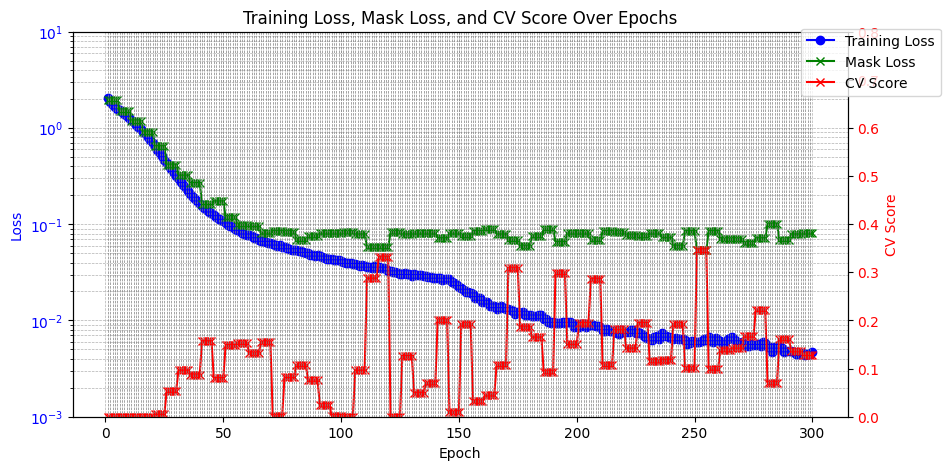

In [12]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左側の軸（Training LossとMask Loss）
ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss', color='blue')
ax1.plot(range(1, len(mask_losses) + 1), mask_losses, marker='x', label='Mask Loss', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')  # 対数スケール（任意）
ax1.set_ylim(0.001, 10) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 右側の軸（CV Score）
ax2 = ax1.twinx()
ax2.plot(range(1, len(cv_scores) + 1), cv_scores, marker='x', label='CV Score', color='red')
ax2.set_ylabel('CV Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 0.8)

# 凡例を追加
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
plt.title('Training Loss, Mask Loss, and CV Score Over Epochs')

#薄い線を追加
for i in range(1, len(epoch_losses)):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# グラフ表示
plt.show()

In [13]:
num_epochs = 100
learning_rate = 1e-4
accumulation_steps = 4  # 勾配を累積するステップ数

optimizer = torch.optim.AdamW(
    net.parameters(),
    amsgrad=False,
    betas=(0.9, 0.999),
    capturable=False,
    differentiable=False,
    eps=1e-08,
    foreach=None,
    fused=None,
    lr=learning_rate,
    weight_decay=0.01
)

warmup_steps = 30
total_steps = num_epochs * len(dataloader)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))  # 線形ウォームアップ
    return 0.5 * (1. + np.cos(np.pi * (current_step - warmup_steps) / (total_steps - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(init_scale=4096)
global_step = 0

for epoch in range(num_epochs):
    if False:  # epoch % 5 == 0 を無効化
        optimizer = torch.optim.AdamW(
            net.parameters(),
            amsgrad=False,
            betas=(0.9, 0.999),
            capturable=False,
            differentiable=False,
            eps=1e-08,
            foreach=None,
            fused=None,
            lr=learning_rate,
            weight_decay=0.01
        )

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        # 1次元削減
        volumes = volumes.squeeze(0)
        masks = masks.squeeze(0)

        batch, D, H, W = volumes.shape

        if np.sum(masks) == 0:
            continue
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }

        optimizer.zero_grad(set_to_none=True) if i % accumulation_steps == 0 else None

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss'] / accumulation_steps  # 累積ステップ数でスケーリング

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            global_step += 1

        running_loss += loss.item() * accumulation_steps  # スケーリングを戻して加算

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"train_loss: {epoch_loss:.4f}")
    # 15エポックごとにCVスコアを計算
    if  epoch  % 5 == 0:
        gb, lb_score, mask_loss,probability = evaluate_cv(net, test_id, cfg, valid_dir, device, mask_size2)
        print(f"valid_loss: {np.mean(mask_loss):.4f}")
        print(f"CVスコア {lb_score:.4f}")  # test_id: 検証用データIDリスト
        print(gb[["particle_type", "P", "T", "hit", "precision", "recall", "f-beta4"]])
    cv_scores.append(lb_score)
    #lbスコアが最大のモデルを保存
    if lb_score == max(cv_scores):
        torch.save({'state_dict': net.state_dict()}, '../model/resnet34d.pth')
    mask_losses.append(np.mean(mask_loss))

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


エポック 1/100
----------
train_loss: 0.0047
valid_loss: 0.0761
CVスコア 0.1413
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   18  82    8   0.444444  0.097561  0.102256
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-galactosidase   93  36    0   0.000000  0.000000  0.000000
3             ribosome  107  96   39   0.364486  0.406250  0.403530
4        thyroglobulin  150  79    0   0.000000  0.000000  0.000000
5  virus-like-particle   73  24   13   0.178082  0.541667  0.483589
エポック 2/100
----------
train_loss: 0.0041
エポック 3/100
----------
train_loss: 0.0041
エポック 4/100
----------
train_loss: 0.0039
エポック 5/100
----------
train_loss: 0.0040
エポック 6/100
----------
train_loss: 0.0036
valid_loss: 0.0875
CVスコア 0.1236
         particle_type    P   T  hit  precision    recall   f-beta4
0         apo-ferritin   24  82    6   0.250000  0.073171  0.076347
1         beta-amylase    0  31    0   0.000000  0.000000  0.000000
2   beta-g

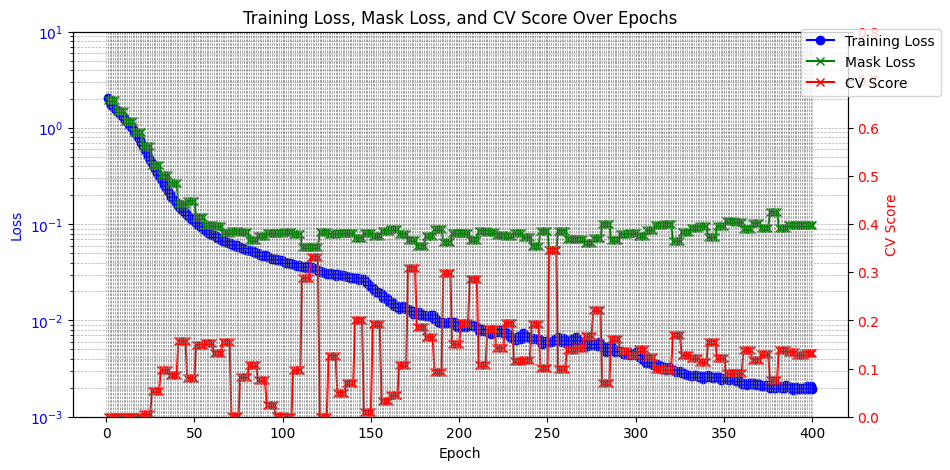

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左側の軸（Training LossとMask Loss）
ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss', color='blue')
ax1.plot(range(1, len(mask_losses) + 1), mask_losses, marker='x', label='Mask Loss', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')  # 対数スケール（任意）
ax1.set_ylim(0.001, 10) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 右側の軸（CV Score）
ax2 = ax1.twinx()
ax2.plot(range(1, len(cv_scores) + 1), cv_scores, marker='x', label='CV Score', color='red')
ax2.set_ylabel('CV Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 0.8)

# 凡例を追加
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
plt.title('Training Loss, Mask Loss, and CV Score Over Epochs')

#薄い線を追加
for i in range(1, len(epoch_losses)):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# グラフ表示
plt.show()

In [15]:
volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data

        y = read_one_truth(valid_id[idx], f'{valid_dir}/overlay/ExperimentRuns')
        mask_data = generate_mask(y, mask_size2)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

(2, 184, 630, 630)
(2, 184, 630, 630)


Text(0.5, 1.0, 'truth')

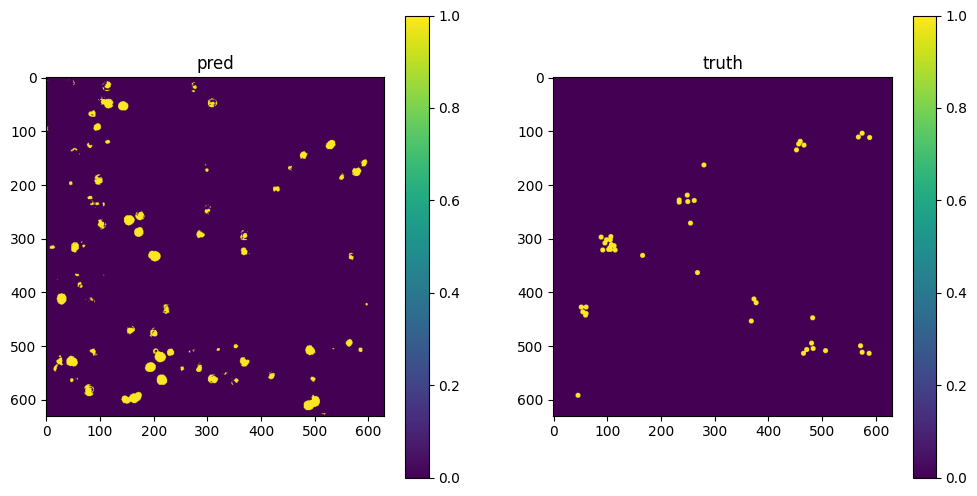

In [16]:
Class =1
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

im1 = axes[0].imshow(probability[Class].max(0)>0.01)
fig.colorbar(im1, ax=axes[0])
axes[0].set_title('pred')

on_hot =np.eye(7)[masks]
im2 = axes[1].imshow(on_hot[0,:,:,:,Class].max(0))
fig.colorbar(im2, ax=axes[1])
axes[1].set_title('truth')